<a href="https://colab.research.google.com/github/msagoo93/CMPE-152-assignment-3/blob/master/microschedules_interleaved_vs_serial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Building a Concert App using SQL Transactions

In [1]:
"""
Example1 TicketMaster's Concert transaction
Users can purchase tickets and get ticket refunds
"""

import sqlite3
import random

# Create a connection to an in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# Create the Concerts table
cursor.execute("""
CREATE TABLE Concerts (
  id INTEGER PRIMARY KEY,
  name TEXT NOT NULL,
  available_tickets INTEGER NOT NULL
);""")

# Add some sample concert data
concerts_data = [
    ('Concert 1', 10),
    ('Concert 2', 5),
    ('Concert 3', 15)
]

cursor.executemany("""
INSERT INTO Concerts (name, available_tickets) VALUES (?, ?)
""", concerts_data)

# Commit the changes
conn.commit()

def purchase_ticket(concert_id):
  print(f'Purchasing for {concert_id=}')
  with conn:
    # Begin a new transaction
    cursor.execute("""BEGIN;""")

    # Get the number of available_tickets for the specified concert_id
    cursor.execute("""
      SELECT available_tickets FROM Concerts WHERE id = ?;""", (concert_id,))
    available_tickets = cursor.fetchone()[0]

    # Check if there are any tickets available for the specified concert
    if available_tickets > 0:
      # Simulate payment processing to Visa/Stripe with a 50% chance of failure
      payment_successful = random.choice([True, False])

      # If payment is successful, update the number of available_tickets
      if payment_successful:
        cursor.execute("""
        UPDATE Concerts SET available_tickets = available_tickets - 1 WHERE id = ?;
                        """, (concert_id,))
      else:
        # If payment fails, do not update available_tickets and print a message
        print(f"Payment failed for concert_id {concert_id}. No ticket change.")

    # Commit the transaction
    conn.commit()

def refund_ticket(concert_id):
  print(f'Want refund for {concert_id=}')
  with conn:
    # Begin a new transaction
    cursor.execute("""BEGIN;""")

    # Increase the number of available_tickets for the specified concert_id
    cursor.execute("""
    UPDATE Concerts SET available_tickets = available_tickets + 1 WHERE id = ?;
            """, (concert_id,))

    # Commit the transaction
    conn.commit()

# Simulate purchasing and refunding tickets
concert_id = random.randint(1, len(concerts_data))
purchase_ticket(concert_id)
concert_id = random.randint(1, len(concerts_data))
refund_ticket(concert_id)

# Print the final state of the concerts table
cursor.execute("SELECT * FROM Concerts")
print(cursor.fetchall())


Purchasing for concert_id=1
Payment failed for concert_id 1. No ticket change.
Want refund for concert_id=2
[(1, 'Concert 1', 10), (2, 'Concert 2', 6), (3, 'Concert 3', 15)]


In [2]:
# Create the ticket_purchase table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Tickets (
    id INTEGER PRIMARY KEY,
    user_id INTEGER NOT NULL,
    concert_id INTEGER NOT NULL,
    num_tickets INTEGER NOT NULL,
    purchase_time TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
    FOREIGN KEY (concert_id) REFERENCES Concerts(id)
);
""")
cursor.execute("delete from Tickets;")

# Commit the changes
conn.commit()

In [3]:
"""
Example 1.2: Users can only purchase upto 6 tickets.
Here we see two additional patterns of code
- Run a query, get data, and decide if a value needs to be updated
- Run a query to modify another table
"""
def purchase_restricted(user_id, concert_id, num_tickets):
  print(f'Checking purchase restrictions for user_id={user_id}, concert_id={concert_id}, num_tickets={num_tickets}')
  with conn:
    # Begin a new transaction
    cursor.execute("""BEGIN;""")

    # Get the number of tickets purchased by the user
    cursor.execute("""
    SELECT SUM(num_tickets) FROM Tickets WHERE user_id = ?;""", (user_id,))
    num_tickets_purchased = cursor.fetchone()[0]
    # Check if the user has reached the maximum ticket purchase limit
    if (num_tickets_purchased or 0) + num_tickets > 6:
      print("Purchase restriction: Maximum ticket purchase limit reached.")
      return False
    else:
      # Update the number of available tickets for the concert
      cursor.execute("""
      UPDATE Concerts SET available_tickets = available_tickets - ? WHERE id = ?;
      """, (num_tickets, concert_id))

      # Insert the ticket purchase entry into the Tickets table
      cursor.execute("""
      INSERT INTO Tickets (user_id, concert_id, num_tickets) VALUES (?, ?, ?);
      """, (user_id, concert_id, num_tickets))
      # Commit the transaction
      conn.commit()
      return True

# Users trying to buy tickets
for (user, concert, numtix) in [(5, 2, 2), (5, 2, 1), (5, 2, 2), (6, 2, 2), (6, 3, 2)]:
  print('--->',  cursor.execute("""SELECT * FROM Tickets;""").fetchall())
  purchase_restricted(user, concert, numtix)
print('--->', cursor.execute("""SELECT * FROM Tickets;""").fetchall())

---> []
Checking purchase restrictions for user_id=5, concert_id=2, num_tickets=2
---> [(1, 5, 2, 2, '2024-05-01 04:50:54')]
Checking purchase restrictions for user_id=5, concert_id=2, num_tickets=1
---> [(1, 5, 2, 2, '2024-05-01 04:50:54'), (2, 5, 2, 1, '2024-05-01 04:50:54')]
Checking purchase restrictions for user_id=5, concert_id=2, num_tickets=2
---> [(1, 5, 2, 2, '2024-05-01 04:50:54'), (2, 5, 2, 1, '2024-05-01 04:50:54'), (3, 5, 2, 2, '2024-05-01 04:50:54')]
Checking purchase restrictions for user_id=6, concert_id=2, num_tickets=2
---> [(1, 5, 2, 2, '2024-05-01 04:50:54'), (2, 5, 2, 1, '2024-05-01 04:50:54'), (3, 5, 2, 2, '2024-05-01 04:50:54'), (4, 6, 2, 2, '2024-05-01 04:50:54')]
Checking purchase restrictions for user_id=6, concert_id=3, num_tickets=2
---> [(1, 5, 2, 2, '2024-05-01 04:50:54'), (2, 5, 2, 1, '2024-05-01 04:50:54'), (3, 5, 2, 2, '2024-05-01 04:50:54'), (4, 6, 2, 2, '2024-05-01 04:50:54'), (5, 6, 3, 2, '2024-05-01 04:50:54')]


In [4]:
"""
Example 1.3: Find superfans who buy tickets to multiple concerts
Here we see an example of updates based on using more SQL logic
"""

# Create the Users table
cursor.execute("""
CREATE TABLE IF NOT EXISTS Users (
    user_id INTEGER PRIMARY KEY,
    superfan INTEGER
);""")

# No superfans to start
cursor.execute("delete from Users;")
cursor.execute("""
INSERT INTO Users (user_id, superfan)
VALUES (5, 0), (6, 0);""")
conn.commit()

def find_superfans():
    print(f'Find super fans')
    with conn:
        # Begin a new transaction
        cursor.execute("""BEGIN;""")

        # Find users who buy tickets to >= 2 concerts and >=2 tickets
        cursor.execute("""
        UPDATE Users
        SET superfan = 1
        WHERE user_id IN (
          SELECT user_id
          FROM (
          SELECT user_id, COUNT(DISTINCT concert_id) AS distinct_concerts
          FROM Tickets
          GROUP BY user_id
          HAVING SUM(num_tickets) >= 2 AND COUNT(DISTINCT concert_id) >= 2
          ) AS subquery
        );""")
        conn.commit()

find_superfans()
cursor.execute("SELECT * FROM Users;")
print('--->',  cursor.fetchall())


Find super fans
---> [(5, 0), (6, 1)]


In [5]:
conn.close()

**Main takeways of Section 1**
1. We saw examples of transaction blocks like BEGIN and COMMIT that ensure that multiple database operations are executed atomically.

2. We saw how to use SPJ queries with UPDATE and INSERT, to combine and update data from different tables.

3. We saw examples of how to handle errors during database operations. Handling exceptions and rolling back (or not COMMITing) transactions in case of errors helps maintain data consistency.**



# Section 2: [Optional] Visualization Code for below plots -- Optional and Low priority


In [6]:
from IPython.display import Image, display, HTML

def displaySectionCaption(caption, color):
  html_string = f'<hr><strong><p style="color:{color};font-size:16px;">{caption}</p.</strong>'
  display(HTML(html_string))

def displayTable(df, caption):
  df = df.reset_index(drop=True)  # Drop the index column
  table_html = df.to_html(index=False)
  html_string = f'<strong>{caption}</strong>{table_html}'
  display(HTML(html_string))

color_r = "lightblue"
color_w = "orange"
color_req = "green"
color_get = "red"
color_unl = "purple"

In [7]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from enum import Enum

class View(Enum):
    ALL = 0
    LIST = 1
    TIMELINE = 2
    WF_GRAPH = 3

def visualize_macro_schedule(df):
    displayTable(df, "<hr>MacroSchedule.Run()")
    # Sort the transactions in ascending order (T1, T2, T3, ...)
    df['Transaction'] = pd.Categorical(df['Transaction'], ordered=True, categories=sorted(df['Transaction'].unique()))
    df = df.sort_values(['Step', 'Transaction'], ascending=True)
    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(10, 5))

    for i, transaction in enumerate(df["Transaction"].unique()):
        filtered_df = df[df["Transaction"] == transaction]
        for _, row in filtered_df.iterrows():
            color = color_r if row["Action"] == "R" else color_w
            tm = row["Step"]
            ax.broken_barh([(tm, 1)], (i - 0.6, 0.8),
                           facecolors=color,
                           edgecolor="grey",
                           linewidth=1)
            ax.text(tm + 0.2, i, f"{row['Variable']}:{row['Value']}", fontsize=14, color="black")

    # Customize the plot
    ax.set_yticks(range(len(df["Transaction"].unique())))
    ax.set_yticklabels(df["Transaction"].unique())
    ax.set_xlabel("Step")
    ax.set_ylabel("Transactions")
    ax.set_title("MacroSchedule.Run() - Timeline View")
    plt.show()

def visualize_micro_schedule(schedule, verbose):
    transactions = sorted(set([action[0] for action in schedule]))
    time_units = sorted(set([action[3] for action in schedule]))
    txn_indices = {txn: i for i, txn in enumerate(transactions)}

    fig, ax = plt.subplots(figsize=(24, 8))
    box_height = 0.8
    box_width = 0.4
    arrow_length = 0.3

    for action in schedule:
        txn, op, var, time = action
        y = txn_indices[txn]
        x = time  # Use the time value directly

        if op[:3] in ["Rs(", "Re(", "Ws(", "We("]:
            if op.startswith("We"):
                box = patches.Rectangle((x, y + 0.1 * box_height), box_width, 0.2 * box_height, edgecolor="grey", facecolor=color_w)
            elif op.startswith("Re"):
                box = patches.Rectangle((x, y + 0.1 * box_height), box_width, 0.2 * box_height, edgecolor="grey", facecolor=color_r)
            else:
                box = patches.Rectangle((x, y + 0.1 * box_height), box_width, 0.2 * box_height, edgecolor="grey", facecolor="none")
            ax.add_patch(box)
            ax.text(x + 0.5 * box_width, y , op, horizontalalignment="center", verticalalignment="center")
        else:
            ytic = 0.1
            if op.startswith("Req"):
                color = color_req
                ytic = 0.25
            elif op.startswith("Get"):
                color = color_get
            elif op.startswith("Unl"):
                color = color_unl
            arrow = patches.Arrow(x + 0.5 * box_width, y, 0,
                                  arrow_length+ytic, width=0.1, color=color)
            ax.add_patch(arrow)

            ax.text(x + 0.3 * box_width, y + arrow_length + ytic, op,
                    horizontalalignment="center", fontsize=11)

        ax.text(x + 0.5 * box_width, y - 0.25, time,
                horizontalalignment="center", fontsize=10)

    ax.set_xlim(0, max(time_units))
    ax.set_ylim(-1, len(transactions))
    ax.set_xticks(range(0, max(time_units) + 5))
    ax.set_yticks(range(len(transactions)))
    ax.set_xticklabels(range(0, max(time_units) + 5))  # Use numerical indices instead of time_units
    ax.set_yticklabels(transactions)
    ax.set_xlabel("Time Units")
    ax.set_ylabel("Transactions")

    plt.show()
    if verbose == View.LIST or verbose == View.ALL:
        # Display the Pandas DataFrame with the schedule
        df_schedule = pd.DataFrame(schedule, columns=["Transaction", "Operation", "Variable", "Time"])
        displayTable(df_schedule, "Micro Schedule")

# Section 3: Conflict Graphs and Conflict Serializability

## 3.1 Macro Schedules

**Input**: A macro schedule, which is an ordered set of actions from concurrent transactions.

**Goal**: Check if the schedule yields consistent (good) or anomalous (bad) results.

**Steps**:
1. Detect Conflicting Actions: Spot actions conflicting due to shared resources.
2. Build Conflict Graph: Create a graph with transactions as nodes and conflicts as edges.
3. Test Conflict Graph Acyclicity: An acyclic graph signals a conflict-serializable schedule, ensuring consistency.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Digraph
import pandas as pd

"""
MacroSchedule provides methods to identify conflicting actions,
draw conflict graphs, check if the schedule is conflict serializable,
and create equivalent serial schedules.
"""
class MacroSchedule:
  def __init__(self, schedule):
    self.schedule = schedule
    self.conflicts = []

  def is_conflicting(self, action1, action2):
    # If there is a W?
    if 'W' in (action1[1], action2[1]):
        return True
    ##
    # Below code is to handle micro schedules with Rs, Rb, Ws, Wb conflicts
    # Doing this, so we can also show how to compute conflicts given a
    # micro schedule.
    action1_type = action1[1][:2]
    action2_type = action2[1][:2]
    valid_actions = {"Ws", "Rs"}

    # Ensure both actions are either "Rs" or "Ws"
    if not (action1_type in valid_actions and action2_type in valid_actions):
        return False

    # Ensure at least one action is "Ws" (We are looking for Writes)
    if 'Ws' not in (action1_type, action2_type):
        return False

    return action1[0] != action2[0] and action1[2] == action2[2]

  def find_conflicting_actions(self, debug=False):
    conflicts = []
    actions = [(i, action) for i, action in enumerate(self.schedule)]

    for i, action1 in actions:
      for j, action2 in actions[i + 1:]:
        # Different transactions and same variable, and conflict?
        if action1[0] != action2[0] and action1[2] == action2[2] and \
          self.is_conflicting(action1, action2):
          conflicts.append((action1[0], action2[0], action1[2],
                          action1[3], action2[3]))
    df = pd.DataFrame(conflicts, columns=["Txn 1", "Txn 2", "Variable",
                                          "Step(Txn 1)", "Step(Txn 2)"])
    if debug:
      displayTable(df, "Conflicting Actions")
    self.conflicts = conflicts
    return conflicts

  def draw_conflict_graph(self):
    g = Digraph('ConflictGraph', format='png')
    g.attr('graph', rankdir='LR', ranksep='2')
    g.attr('node', style='filled', color='lightblue')

    # Sort the conflicts list based on the transaction names
    sorted_conflicts = sorted(self.conflicts, key=lambda x: x[:2])

    # Add nodes to the graph for each unique transaction involved in a conflict
    for conflict in sorted_conflicts:
      g.node(conflict[0])
      g.node(conflict[1])

    # Add edges with labels indicating the conflicting variable and actions
    for conflict in sorted_conflicts:
      elabel = f'{conflict[2]}-(#{conflict[3]},#{conflict[4]})'
      g.edge(conflict[0], conflict[1], label=elabel)

    # Render the graph to a PNG and display inline
    g.render('conflict_graph', format='png')
    display(Image(filename='conflict_graph.png'))

  def is_conflict_serializable(self):
    # Create a directed graph using NetworkX
    G = nx.DiGraph()

    # Add edges from the conflicts list to the graph
    for conflict in self.conflicts:
      G.add_edge(conflict[0], conflict[1])

    # Check for cycles in the graph
    cycles = list(nx.simple_cycles(G))

    # If there are no cycles, the graph is acyclic, and the schedule is
    # conflict serializable
    if not cycles:
      print("The schedule is conflict serializable.")
    else:
      print("The schedule is not conflict serializable.")
      print(f"Example cycles: {cycles}")

  def create_equiv_serial_schedule(self):
    schedule = self.schedule
    conflicts = self.conflicts
    G = nx.DiGraph()

    # Add nodes and edges to the conflict graph
    for conflict in conflicts:
      G.add_edge(conflict[0], conflict[1])

    # Perform a topological sort on the conflict graph
    try:
      serial_order = list(nx.topological_sort(G))
    except nx.NetworkXUnfeasible:
      cycles = list(nx.simple_cycles(G))
      print("Schedule is not conflict serializable.")
      print(f"Example cycles: {cycles}")
      return None

    # Combine the actions of each transaction in the serial order
    serial_schedule = []
    counter = 1
    for transaction in serial_order:
      actions = [action for action in schedule if action[0] == transaction]
      for action in actions:
        updated_action = (action[0], action[1], action[2], counter)
        serial_schedule.append(updated_action)
        counter += 1
    df = pd.DataFrame(serial_schedule, columns=["Transaction", "Action", "Variable", "Step"])
    displayTable(df, "Equivalent Serial Schedule")
    return serial_schedule

  def analyze_conflicts(self):
    self.find_conflicting_actions(debug=True)
    self.draw_conflict_graph()
    self.create_equiv_serial_schedule()

# Run a MacroSchedule to see what the end states are
class MacroScheduleRun(MacroSchedule):
  def __init__(self, schedule, initial_values):
    super().__init__(schedule)
    self.schedule = schedule
    self.initial_values = initial_values
    self.transaction_values = {}
    self.first_read = {}
    # Initialize the current values
    self.current_values = initial_values.copy()
    # Create a dataframe from the schedule
    self.df = pd.DataFrame(self.schedule,
                           columns=["Transaction", "Action", "Variable", "Step"])

  # Update the current values of A and B for each operation
  def run_actions(self, row):
    # Modify to mimic how 'W' action modifies a value
    def update_function(old_value):
      return old_value - 1
      #return round(old_value * 1.2, 2)

    transaction = row['Transaction']
    variable = row['Variable']
    if transaction not in self.transaction_values:
      self.transaction_values[transaction] = self.current_values.copy()
      self.first_read[transaction] = {var: True for var in self.initial_values.keys()}

    if row['Action'] == 'R' and self.first_read[transaction][variable]:
      self.transaction_values[transaction][variable] = self.current_values[variable]
      self.first_read[transaction][variable] = False
    elif row['Action'] == 'W': #
      self.transaction_values[transaction][variable] = \
      update_function(self.transaction_values[transaction][variable])

      self.current_values[variable] = self.transaction_values[transaction][variable]

    return self.transaction_values[transaction][variable]

  def run_schedule(self):
    self.df['Value'] = self.df.apply(self.run_actions, axis=1)
    visualize_macro_schedule(self.df)



### 3.1 Example MacroSchedules

We'll see a few examples of macroschedules. We'll compute (1) conflicting actions, (2) ConflictGraph, (3) check if the given schedule is Conflict-Serializable (CS) or not.
--
* 3 TXNs, 2 variables -- a serial macroschedule
* 3 TXNs, 2 variables -- an interleaved macroschedule. CS!
* 3 TXNs, 2 variables -- An interleaved bad (macro)schedule. Non CS.
* 3 TXNs, 2 variables -- Another interleaved bad (macro) schedule. Non CS.




Txn 1,Txn 2,Variable,Step(Txn 1),Step(Txn 2)
T1,T2,A,2,3
T2,T3,B,4,7
T2,T3,B,5,6
T2,T3,B,5,7


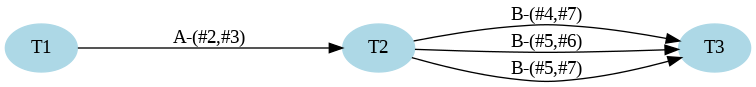

Transaction,Action,Variable,Step
T1,R,A,1
T1,W,A,2
T2,R,A,3
T2,R,B,4
T2,W,B,5
T3,R,B,6
T3,W,B,7


Transaction,Action,Variable,Step,Value
T1,R,A,1,10
T1,W,A,2,9
T2,R,A,3,9
T2,R,B,4,22
T2,W,B,5,21
T3,R,B,6,21
T3,W,B,7,20


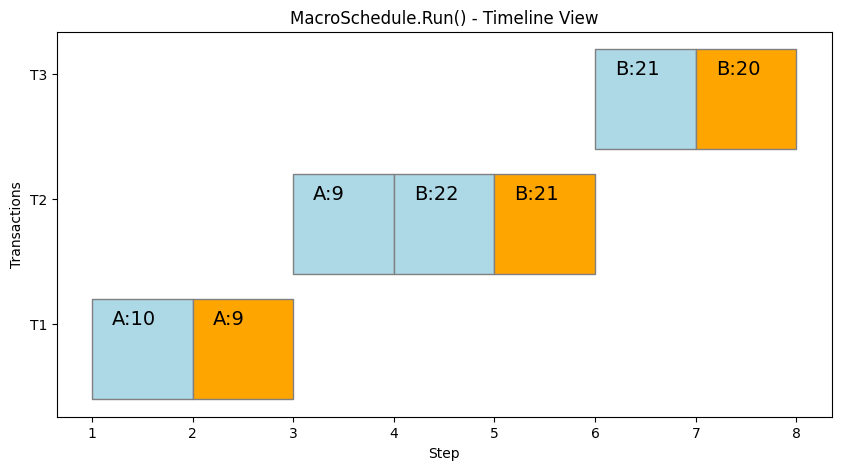

In [9]:
"""
Example 3.1.1: A (and B) refers to avail_tickets in Concert A (and Concert B).
- T1 purchases A. T2 reviews A and B, and purchases B. T3 purchases B.
- Sample serial schedule of T1 --> T2 --> T3.
"""
available_tickets = {'A': 10, 'B': 22}
SS = [
    ("T1", "R", "A", 1), # T1.R(A) in Step1
    ("T1", "W", "A", 2), # T1.W(A) in Step2
    ("T2", "R", "A", 3), # T2.R(A) in Step3
    ("T2", "R", "B", 4),
    ("T2", "W", "B", 5),
    ("T3", "R", "B", 6),
    ("T3", "W", "B", 7),
    #("T3", "W", "A", 8), # Play: With different actions

]

macro = MacroSchedule(SS)
macro.analyze_conflicts()
macrorun = MacroScheduleRun(SS, available_tickets)
macrorun.run_schedule()

Txn 1,Txn 2,Variable,Step(Txn 1),Step(Txn 2)
T2,T1,A,2,3
T2,T3,B,4,7
T2,T3,B,5,6
T2,T3,B,5,7


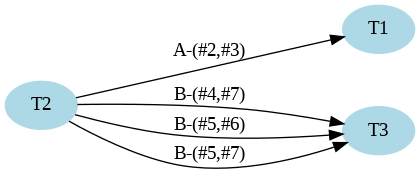

Transaction,Action,Variable,Step
T2,R,A,1
T2,R,B,2
T2,W,B,3
T1,R,A,4
T1,W,A,5
T3,R,B,6
T3,W,B,7


Transaction,Action,Variable,Step,Value
T1,R,A,1,10
T2,R,A,2,10
T1,W,A,3,9
T2,R,B,4,22
T2,W,B,5,21
T3,R,B,6,21
T3,W,B,7,20


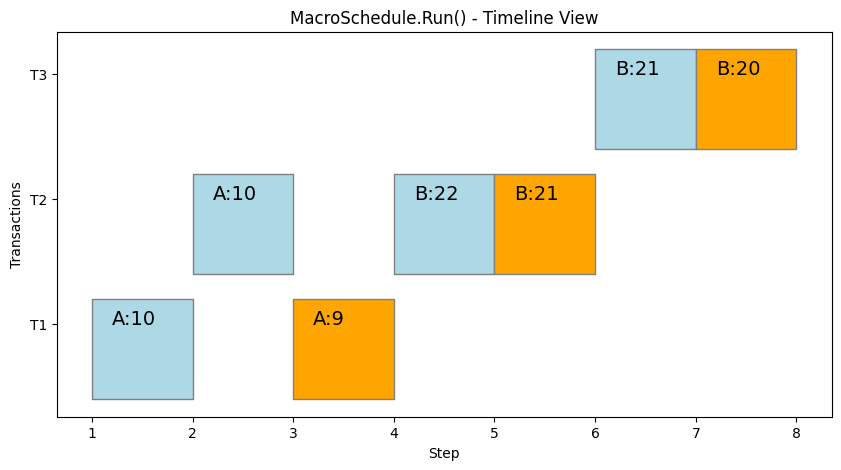

In [10]:
# Example 3.1.2: S1: Sample interleaved schedule
S1 = [
    ("T1", "R", "A", 1), # T1.R(A) in Step1
    ("T2", "R", "A", 2), # T2.R(A) in Step2
    ("T1", "W", "A", 3), # T1.W(A) in Step3
    ("T2", "R", "B", 4), # T2.R(B) in Step4
    ("T2", "W", "B", 5), # T2.W(B) in Step5
    ("T3", "R", "B", 6), # T3.R(B) in Step6
    ("T3", "W", "B", 7), # T3.W(B) in Step7
    #("T3", "W", "A", 8), # Play with other actions

]
macro = MacroSchedule(S1)
macro.analyze_conflicts()

macrorun = MacroScheduleRun(S1, available_tickets)
macrorun.run_schedule()


Txn 1,Txn 2,Variable,Step(Txn 1),Step(Txn 2)
T2,T1,A,2,3
T2,T3,B,4,7
T2,T3,B,5,6
T2,T3,B,5,7
T3,T2,B,6,9
T3,T2,B,7,9


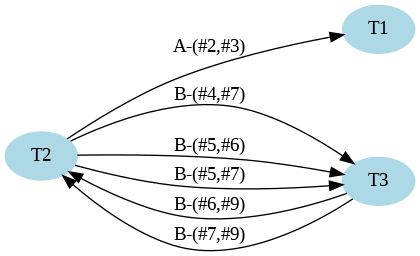

Schedule is not conflict serializable.
Example cycles: [['T2', 'T3']]


Transaction,Action,Variable,Step,Value
T1,R,A,1,10
T2,R,A,2,10
T1,W,A,3,9
T2,R,B,4,22
T2,W,B,5,21
T3,R,B,6,21
T3,W,B,7,20
T2,W,B,9,20


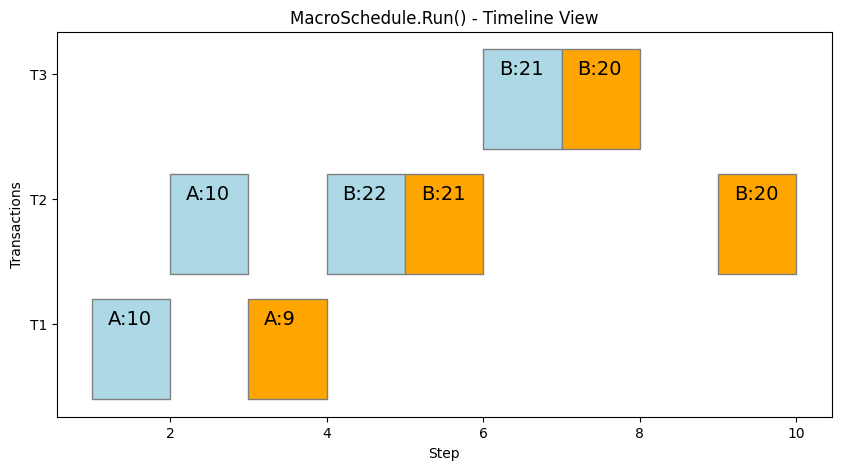

In [11]:
"""
Example 3.1.3
In T2, user buys an extra ticket for B in this schedule.

Output: We see the schedule is no longer conflict-serializable.
Takeaway: Minor schedule changes can make a DB inconsistent.
"""
S2 = S1 + [("T2", "W", "B", 9)] # Example Schedule S2
macro = MacroSchedule(S2)
macro.analyze_conflicts()
macrorun = MacroScheduleRun(S2, available_tickets)
macrorun.run_schedule()

Txn 1,Txn 2,Variable,Step(Txn 1),Step(Txn 2)
T2,T1,A,2,3
T2,T3,B,4,7
T2,T3,B,4,10
T2,T3,B,5,6
T2,T3,B,5,7
T2,T3,B,5,10
T3,T2,B,6,9
T3,T2,B,6,9
T3,T2,B,7,9
T3,T2,B,7,9


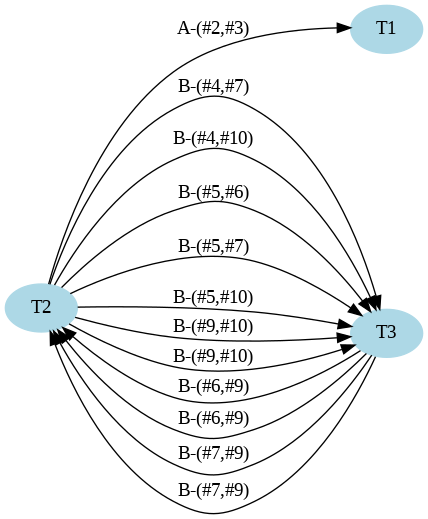

Schedule is not conflict serializable.
Example cycles: [['T2', 'T3']]


Transaction,Action,Variable,Step,Value
T1,R,A,1,10
T2,R,A,2,10
T1,W,A,3,9
T2,R,B,4,22
T2,W,B,5,21
T3,R,B,6,21
T3,W,B,7,20
T2,W,B,9,20
T2,W,B,9,19
T3,W,B,10,19


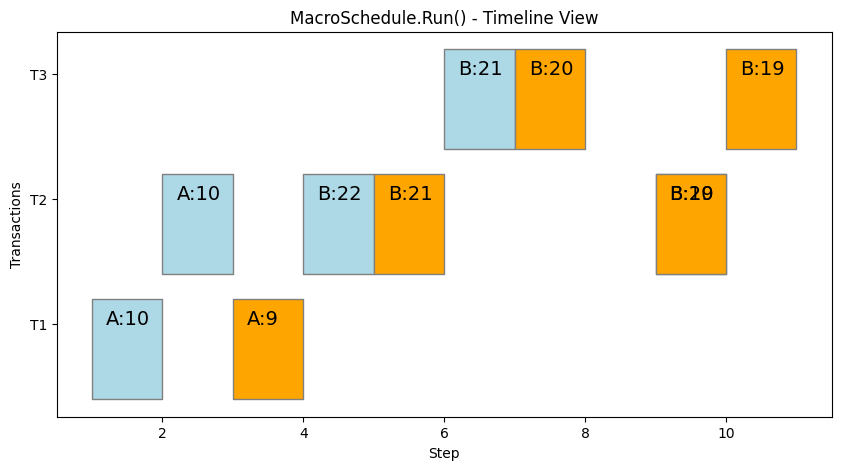

In [12]:
# Example 3.1.4: Another non conflict-serializable schedule
S3 = S2 + [("T2", "W", "B", 9), ("T3", "W", "B", 10)] # Example Schedule S3
macro = MacroSchedule(S3)
macro.analyze_conflicts()
macrorun = MacroScheduleRun(S3, available_tickets)
macrorun.run_schedule()

Txn 1,Txn 2,Variable,Step(Txn 1),Step(Txn 2)
T1,T2,A,1,2
T1,T4,B,3,6
T3,T2,C,4,5
T2,T5,D,7,9
T4,T5,E,8,10


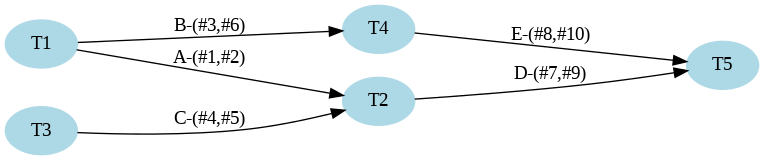

Transaction,Action,Variable,Step
T1,W,A,1
T1,W,B,2
T3,W,C,3
T4,R,B,4
T4,W,E,5
T2,R,A,6
T2,R,C,7
T2,W,D,8
T5,R,D,9
T5,W,E,10


Transaction,Action,Variable,Step,Value
T1,W,A,1,9
T2,R,A,2,9
T1,W,B,3,21
T3,W,C,4,40
T2,R,C,5,40
T4,R,B,6,21
T2,W,D,7,80
T4,W,E,8,46
T5,R,D,9,80
T5,W,E,10,45


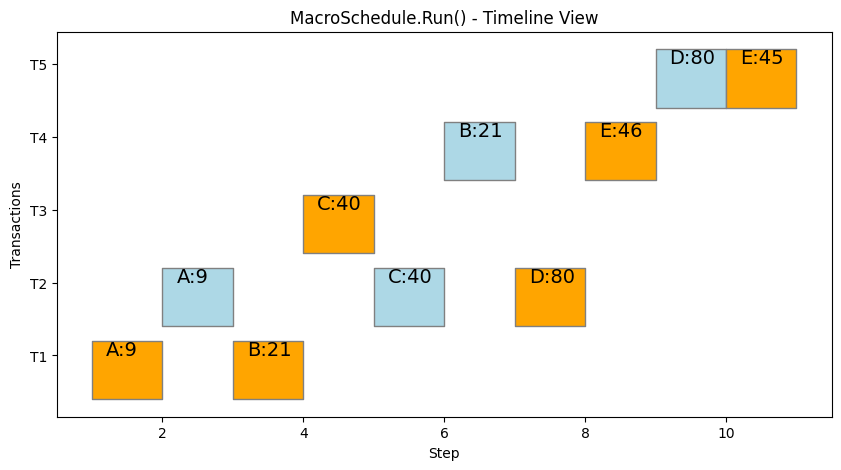

In [13]:
# Example 3.1.5: A 5 transaction schedule
S5 = [
    ("T1", "W", "A", 1),
    ("T2", "R", "A", 2),
    ("T1", "W", "B", 3),
    ("T3", "W", "C", 4),
    ("T2", "R", "C", 5),
    ("T4", "R", "B", 6),
    ("T2", "W", "D", 7),
    ("T4", "W", "E", 8),
    ("T5", "R", "D", 9),
    ("T5", "W", "E", 10),
]
macro = MacroSchedule(S5)
macro.analyze_conflicts()
num_likes = {'A': 10, 'B': 22, 'C': 41, 'D': 81, 'E': 47}
macrorun = MacroScheduleRun(S5, num_likes)
macrorun.run_schedule()

**Takeaways**:
1. Focus on the macroschedules. Get intuition for correct and incorrect reorderings. Focus on the ideas and algorithms. The code is there to help you go deeper, but don't stress about the code.
2. Play with different actions at different steps. See how the Conflicts and Conflict Graphs change.


## 3.2 Micro Schedules
**Input**: A collection of parallel transactions with specified Read/Write (R/W) operations for each transaction.

**Goal**: Generate detailed micro schedules, providing precise locking information (Request, Get, Unlock) and execution timing for each IO action.

**Steps**:
1. Generate the "straightforward" serial micro schedule, with transactions going serially, one after the other.
2. Generate the interleaved micro schedule: Here, we rearrange the actions using Strict 2-Phase Locking (S2PL) rules (Hold all locks till transaction commits/aborts). The sequence of actions is mixed from different transactions to improve performance and resource utilization.

**Key Data Structures**: Track each transaction's locks  and wait times for lock acquisition (e.g., T1 is waiting on T3 for 'B'). We also utilize a 'Waits-For' graph to visualize and manage transaction dependencies and detect potential deadlocks.


In [14]:
import random
random.seed(42)

"""
MicroSchedule models micro schedules for both serial and interleaved schedules,
reresenting important details of locks and IO lags for read/write actions.
"""
class MicroSchedule():
  def __init__(self, transactions, operations, IOlag):
    self.transactions = transactions
    self.operations = operations
    self.IOlag = IOlag
    return

  def create_local_schedule(self, txn, tm=0):
    local_schedule = []  # Initialize an empty list for the local schedule
    locks_held = set()  # Keep track of locks held by the transaction

    # Iterate through the provided operations
    for op in self.operations:
      if op[0] == txn:  # If the operation belongs to the current transaction
        var = op[2]   # Extract the variable involved in the operation

        # If the transaction doesn't already hold a lock on the variable,
        # add lock request and get operations
        if var not in locks_held:
          local_schedule.append((txn, f"Req({var})", var, tm))
          tm += 1
          local_schedule.append((txn, f"Get({var})", var, tm))
          tm += 1
          locks_held.add(var)
        # Rewrite R(var) into Read start and Read end operations
        # That is, Rs(var) and Re(var) separated by IOlag time units
        # Same for Write operation
        local_schedule.append((txn, f"{op[1]}s({var})", var, tm))
        tm += self.IOlag
        local_schedule.append((txn, f"{op[1]}e({var})", var, tm))
        tm += 1

    # Release all locks held by the transaction, with Unlock
    for var in locks_held:
      local_schedule.append((txn, f"Unl({var})", var, tm))
      tm += 1

    return local_schedule, tm  # Return the local schedule and the updated time

  def create_serial_schedule(self):
    global_schedule = []  # Initialize an empty list for the global schedule
    global_tm = 1  # Initialize the global time to 0

    for txn in self.transactions:
      # Create a local schedule for the current transaction
      local_schedule, tm_ls = self.create_local_schedule(txn, global_tm)
      global_schedule += local_schedule  # Append to the global schedule
      global_tm = tm_ls

    return global_schedule, global_tm

  def interleaved_s2pl_schedule(self, serial=False):
    global_schedule = []
    global_tm = 1
    waits_for = {txn: {} for txn in self.transactions}
    random.shuffle(self.transactions)

    for txn in self.transactions:
        time_offset = random.randint(1,2)
        local_schedule = []
        if serial:
          local_schedule, tm_ls = self.create_local_schedule(txn, global_tm)
          global_schedule += local_schedule
          global_tm = tm_ls
          continue
        else:
          local_schedule, tm_ls = self.create_local_schedule(txn)

        for op in local_schedule:
          txn, action, var, time = op
          if var not in waits_for[txn]:
            waits_for[txn][var] = {"Req": None, "Get": None, "Unl": None}

          # Find an available time slot
          while any(existing_op[3] == time + time_offset for existing_op in global_schedule):
            time_offset += 1

          # Handle lock requests and gets
          if action.startswith("Req"):
            waits_for[txn][var]["Req"] = time + time_offset
          elif action.startswith("Get"):
            lock_acquired = False
            while not lock_acquired:
              # Check if another transaction holds the lock
              other_txn_holds_lock = any(
                other_txn != txn and
                waits_for[other_txn].get(var) and
                waits_for[other_txn][var].get("Get") and
                (not waits_for[other_txn][var].get("Unl") or \
                waits_for[other_txn][var]["Unl"] > time + time_offset)
                for other_txn in self.transactions)
              if other_txn_holds_lock:
                time_offset += 1
              else:
                lock_acquired = True
                waits_for[txn][var]["Get"] = time + time_offset
          # Handle lock release
          elif action.startswith("Unl"):
            waits_for[txn][var]["Unl"] = time + time_offset

          # Add operation to the global schedule
          global_schedule.append((txn, action, var, time + time_offset))
          global_tm = max(global_tm, time+time_offset)

    return sorted(global_schedule, key=lambda x: x[3]), waits_for, global_tm


### Waits For Graph

In [15]:
from graphviz import Digraph
from IPython.display import Image
import json

""" Construct the WaitsForGraph from the input per-transaction WaitsForLocks
structure
"""
def draw_waits_for_graph(txn_waits_for_locks):
  html_string = f'<strong>Per-Transaction Locks</strong>'
  display(HTML(html_string))

  for txn in txn_waits_for_locks:
    print(txn)
    for var in txn_waits_for_locks[txn]:
      print(f"    {var}: {json.dumps(txn_waits_for_locks[txn][var])}")

  g = Digraph('WaitsForGraph', format='png')
  g.attr('graph', rankdir='LR', ranksep='2')
  g.attr('node', style='filled', color='lightblue')

  # Add nodes to the graph for each unique transaction
  for transaction in txn_waits_for_locks:
    g.node(transaction)

  # Add edges with labels indicating the waiting variable and time unit
  for txn1, waits_for_vars1 in txn_waits_for_locks.items():
    for txn2, waits_for_vars2 in txn_waits_for_locks.items():
      if txn1 != txn2:
        for var in set(waits_for_vars1.keys()).intersection(waits_for_vars2.keys()):
          lock_info1 = waits_for_vars1[var]
          lock_info2 = waits_for_vars2[var]

          if lock_info1.get("Get") is not None and \
            lock_info2.get("Get") is not None and lock_info2.get("Unl") is not None:
            if lock_info2["Get"] <= lock_info1["Get"] and lock_info2["Unl"] >= lock_info1["Req"]:
              if lock_info2["Get"] >= lock_info1["Req"]:
                elabel = f'{var} ({lock_info2["Get"]}-{lock_info2["Unl"]})'
              else:
                elabel = f'{var} ({lock_info1["Req"]}-{lock_info2["Unl"]})'
              g.edge(txn1, txn2, label=elabel)
          elif lock_info1.get("Req") and lock_info1.get("Get") and not lock_info1.get("Unl"):
            elabel = f'{var} ({lock_info2["Req"]}, _)'
            g.edge(txn2, txn1, label=elabel)

  # Render the graph to a PNG and display inline
  g.render('waits_for_graph', format='png')
  html_string = f'<br><strong>WaitsFor Graph</strong>'
  display(HTML(html_string))
  display(Image(filename='waits_for_graph.png'))

In [18]:

import sys
"""
Goal:
1. Generate multiple interleaved microschedules.
2. Evaluate speedup vs a serial schedule
"""
def evaluate_micro_schedules(transactions, operations, IOlag,
                            num_interleaved_schedules=2, verbose=None):
  micro = MicroSchedule(transactions, operations, IOlag)
  results = []
  serial_schedule, waits_for, serial_time_len = \
        micro.interleaved_s2pl_schedule(serial=True)

  if verbose:
    displaySectionCaption("Serial Schedule with Locks", 'blue')
    visualize_micro_schedule(serial_schedule, verbose)
  min_len = sys.maxsize

  ##
  ## generate multiple interleaved microschedules
  for i in range(num_interleaved_schedules):
    # each microschedule has a waits_for and time_len (how long it takes to
    # execute that microschedule)
    interleaved_schedule, waits_for, interleaved_time_len = \
      micro.interleaved_s2pl_schedule(serial=False)
    print(f'{serial_time_len=}. {interleaved_time_len=}')
    min_len = min(min_len, interleaved_time_len)
    if verbose:
      displaySectionCaption(f"Interleaved Schedule #{i} with Locks", 'blue')
      visualize_micro_schedule(interleaved_schedule, verbose)
      if verbose == View.ALL or verbose == View.WF_GRAPH:
        draw_waits_for_graph(waits_for)

      # To see the Conflict Graph, uncomment below 2 lines
      #macro = MacroSchedule(interleaved_schedule)
      #macro.analyze_conflicts()
  results = [(len(transactions), IOlag, serial_time_len,
              min_len, serial_time_len/min_len)]
  return results

""" Helper function to convert ops to schedule"""
def convert_ops_to_macroschedule(ops):
  ss = []
  step = 1
  for op in ops:
    # Append the step number to the operation tuple
    ss.append((*op, step))
    step += 1
  return ss

### Examples 3.2.1 Locking for Schedules

We see a few examples of microschedules for a set of transactions that are run with S2PL.
1. Given a set of actions, we'll see a serial and a few potential interleaved microschedules. Each of them will have locks and IO lags.
2. For each such microschedule, we'll see the timeline layout, and the WaitsFor Graphs, and how long it takes to run that microschedule.
3. In addition, in a few cases, we'll show the Conflict graph for each microschedule (each microschedule is also a macroschedule -- just drop the Locks and IO lags, and you have an ordered sequence.) Why? To see the ConflictGraphs, and see they're acyclic (and therefore the microschedule is conflict-serializable.)

Txn 1,Txn 2,Variable,Step(Txn 1),Step(Txn 2)
T1,T3,A,1,6
T1,T2,A,2,4
T1,T3,A,2,6
T2,T3,A,4,6


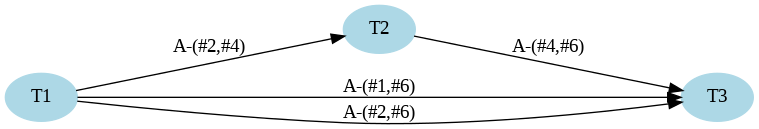

Transaction,Action,Variable,Step
T1,R,A,1
T1,W,A,2
T2,R,A,3
T3,R,B,4
T3,W,B,5
T3,W,A,6


Transaction,Action,Variable,Step,Value
T1,R,A,1,10
T1,W,A,2,9
T3,R,B,3,22
T2,R,A,4,9
T3,W,B,5,21
T3,W,A,6,8


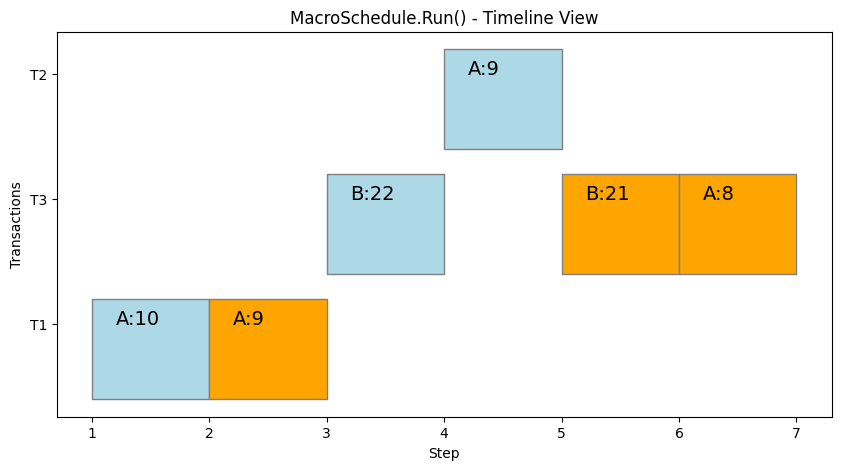

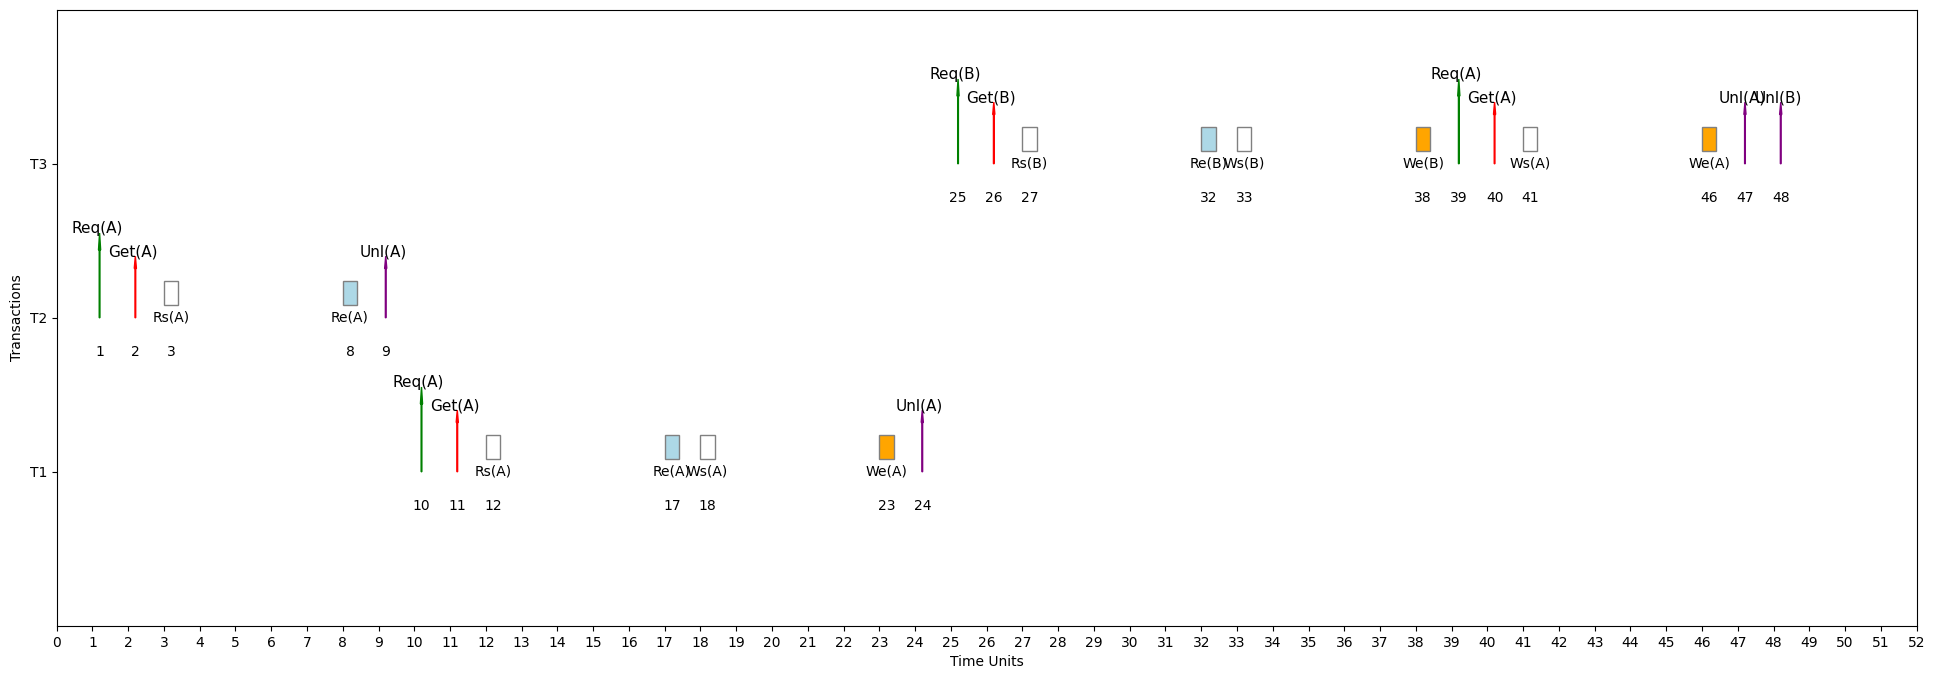

Transaction,Operation,Variable,Time
T2,Req(A),A,1
T2,Get(A),A,2
T2,Rs(A),A,3
T2,Re(A),A,8
T2,Unl(A),A,9
T1,Req(A),A,10
T1,Get(A),A,11
T1,Rs(A),A,12
T1,Re(A),A,17
T1,Ws(A),A,18


serial_time_len=49. interleaved_time_len=34


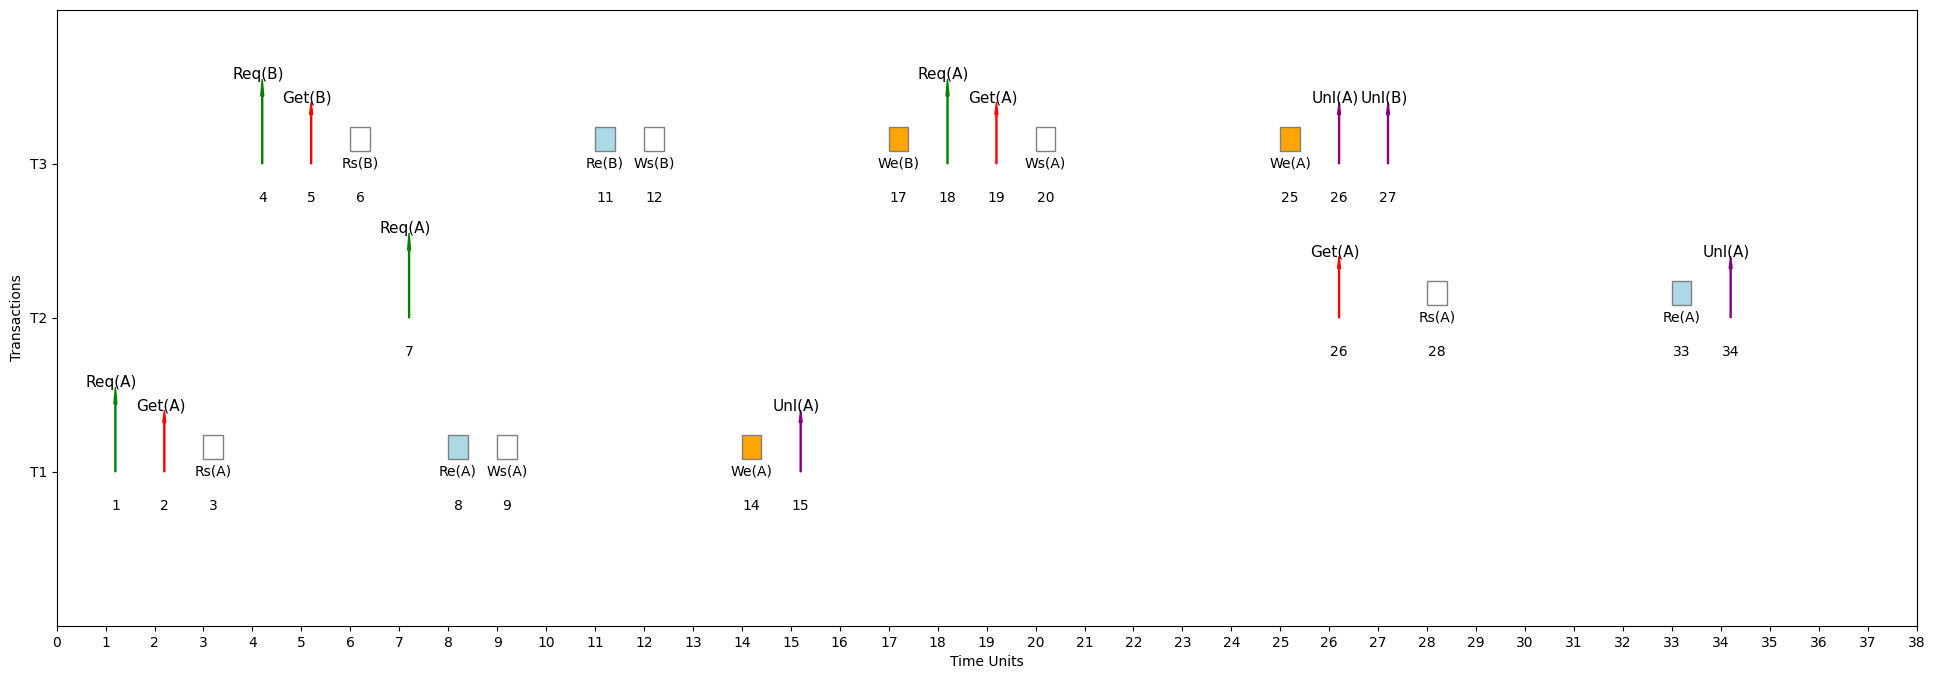

Transaction,Operation,Variable,Time
T1,Req(A),A,1
T1,Get(A),A,2
T1,Rs(A),A,3
T3,Req(B),B,4
T3,Get(B),B,5
T3,Rs(B),B,6
T2,Req(A),A,7
T1,Re(A),A,8
T1,Ws(A),A,9
T3,Re(B),B,11


T2
    A: {"Req": 7, "Get": 26, "Unl": 34}
T1
    A: {"Req": 1, "Get": 2, "Unl": 15}
T3
    B: {"Req": 4, "Get": 5, "Unl": 27}
    A: {"Req": 18, "Get": 19, "Unl": 26}


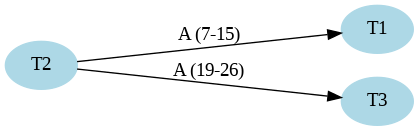

serial_time_len=49. interleaved_time_len=44


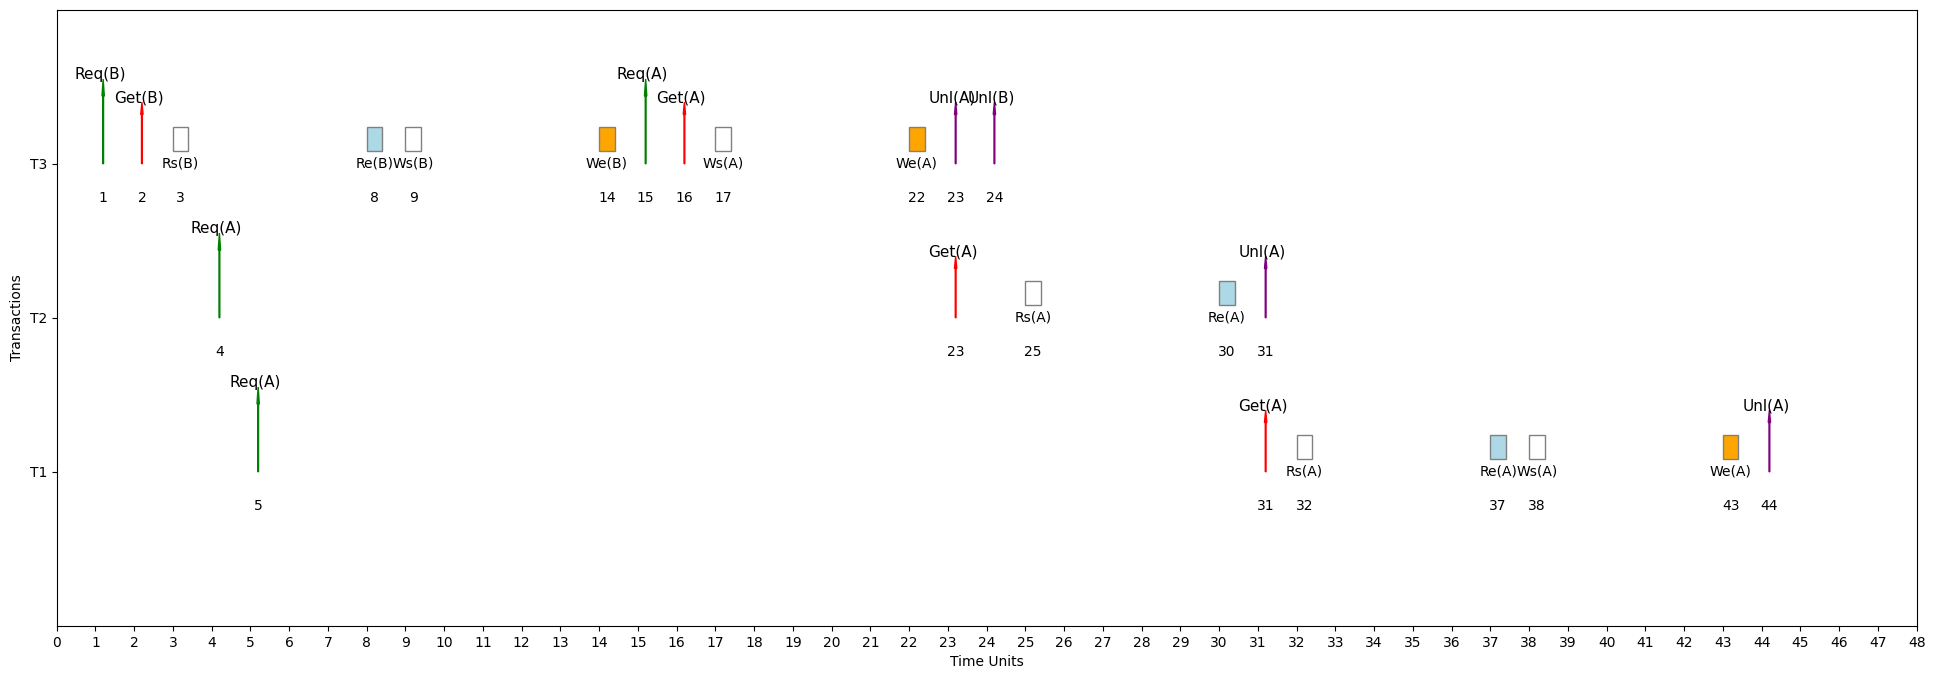

Transaction,Operation,Variable,Time
T3,Req(B),B,1
T3,Get(B),B,2
T3,Rs(B),B,3
T2,Req(A),A,4
T1,Req(A),A,5
T3,Re(B),B,8
T3,Ws(B),B,9
T3,We(B),B,14
T3,Req(A),A,15
T3,Get(A),A,16


T1
    A: {"Req": 5, "Get": 31, "Unl": 44}
T3
    B: {"Req": 1, "Get": 2, "Unl": 24}
    A: {"Req": 15, "Get": 16, "Unl": 23}
T2
    A: {"Req": 4, "Get": 23, "Unl": 31}


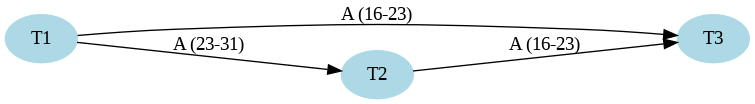

[(3, 5, 49, 34, 1.4411764705882353)]

In [19]:
# Example operations
Txns1 = ["T1", "T2", "T3"]
Ops1 = [
    ("T1", "R", "A"),
    ("T1", "W", "A"),
    ("T3", "R", "B"),
    ("T2", "R", "A"),
    ("T3", "W", "B"),
    ("T3", "W", "A"),
]

""" See the macroschedule to get intuition on correctness.
"""
SS321 = convert_ops_to_macroschedule(Ops1)
macro = MacroSchedule(SS321)
macro.analyze_conflicts()

""" We'll see the serial schedule with the locks and IOlags.
Plus, multiple interleaved schedules.
For these schedules, we'll see the timeline view, per-transaction locks, and
WaitsForGraph.
"""

macrorun = MacroScheduleRun(SS321, available_tickets)
macrorun.run_schedule()
# Play with num_interleaved_schedules, set to 3 or 4, and see other microschedules, and
# each waits for graph
evaluate_micro_schedules(Txns1, Ops1, IOlag=5, num_interleaved_schedules=2,
                         verbose=View.ALL)

### Examples 3.2.2 Schedules with Deadlocks

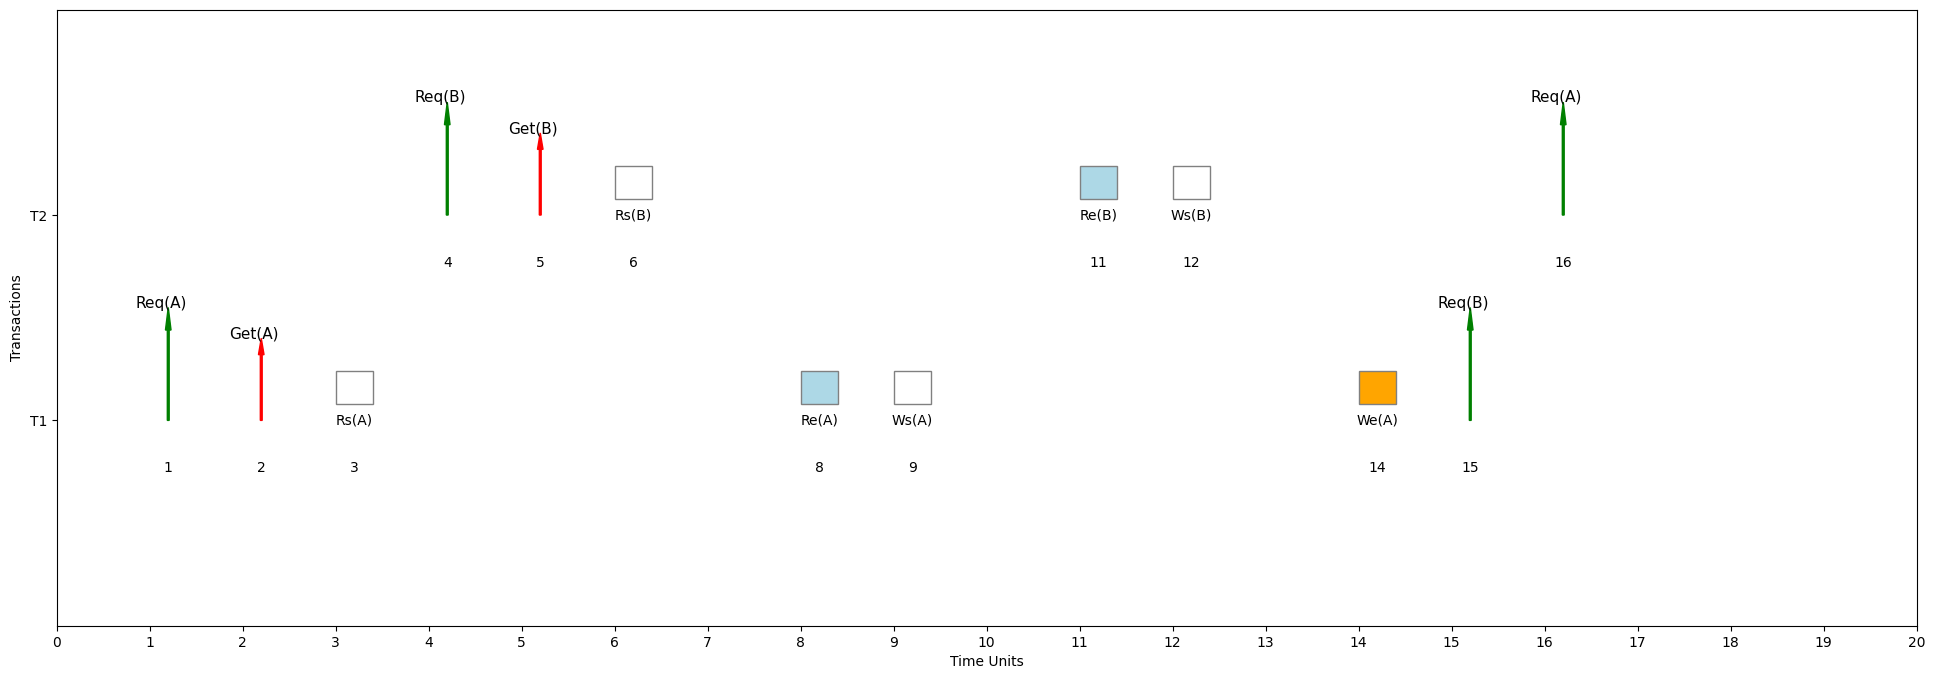

Transaction,Operation,Variable,Time
T1,Req(A),A,1
T1,Get(A),A,2
T1,Rs(A),A,3
T1,Re(A),A,8
T1,Ws(A),A,9
T1,We(A),A,14
T2,Req(B),B,4
T2,Get(B),B,5
T2,Rs(B),B,6
T2,Re(B),B,11


T1
    A: {"Req": 1, "Get": 2}
    B: {"Req": 15}
T2
    A: {"Req": 16}
    B: {"Req": 4, "Get": 5}


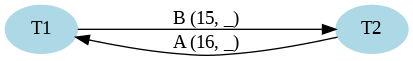

In [20]:
# Set up a deadlock scenario with 2 transactions
deadlock_schedule1 = [
    ("T1", "Req(A)", "A", 1),
    ("T1", "Get(A)", "A", 2),
    ("T1", "Rs(A)", "A", 3),
    ("T1", "Re(A)", "A", 8),
    ("T1", "Ws(A)", "A", 9),
    ("T1", "We(A)", "A", 14),
    ("T2", "Req(B)", "B", 4),
    ("T2", "Get(B)", "B", 5),
    ("T2", "Rs(B)", "B", 6),
    ("T2", "Re(B)", "B", 11),
    ("T2", "Ws(B)", "B", 12),
    ("T1", "Req(B)", "B", 15),
    ("T2", "Req(A)", "A", 16),
    # The deadlock blocks further progress.
]

# waits_for lock sequence for the deadlock scenario
waits_for_deadlock1 = {
    "T1": {
        "A": {"Req": 1, "Get": 2},
        "B": {"Req": 15},
    },
    "T2": {
        "A": {"Req": 16},
        "B": {"Req": 4, "Get": 5},
    },
}

# Visualize the deadlock scenario.
# Change verbose to View.ALL to see list view of schedule.
visualize_micro_schedule(deadlock_schedule1, verbose=View.ALL)
draw_waits_for_graph(waits_for_deadlock1)
#macro = MacroSchedule(deadlock_schedule2)
#macro.analyze_conflicts()


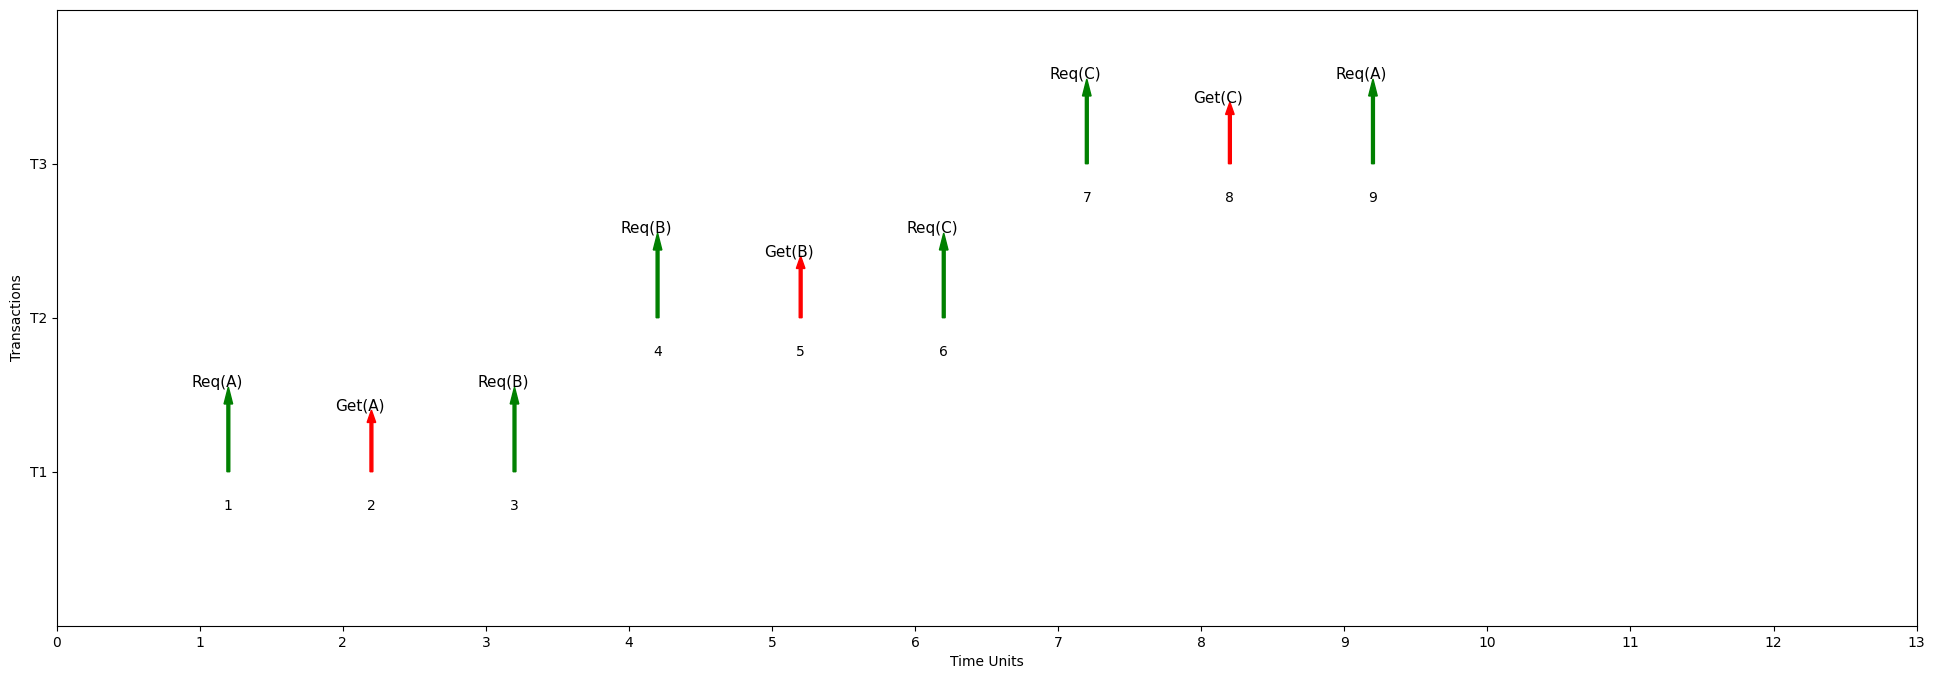

Transaction,Operation,Variable,Time
T1,Req(A),A,1
T1,Get(A),A,2
T1,Req(B),B,3
T2,Req(B),B,4
T2,Get(B),B,5
T2,Req(C),C,6
T3,Req(C),C,7
T3,Get(C),C,8
T3,Req(A),A,9


T1
    A: {"Req": 1, "Get": 2}
    B: {"Req": 3}
T2
    B: {"Req": 4, "Get": 5}
    C: {"Req": 6}
T3
    C: {"Req": 7, "Get": 8}
    A: {"Req": 9}


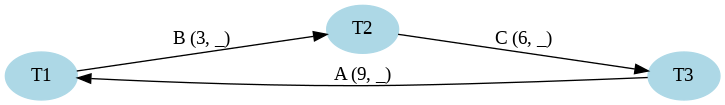

In [21]:
""" Deadlock example with 3 transactions.
Here we only show Req and Get ops. Often, we drop the R and W operations to be
more compact
"""
deadlock_schedule2 = [
    ("T1", "Req(A)", "A", 1),
    ("T1", "Get(A)", "A", 2),
    ("T1", "Req(B)", "B", 3),
    ("T2", "Req(B)", "B", 4),
    ("T2", "Get(B)", "B", 5),
    ("T2", "Req(C)", "C", 6),
    ("T3", "Req(C)", "C", 7),
    ("T3", "Get(C)", "C", 8),
    ("T3", "Req(A)", "A", 9),
    # The rest of the schedule is omitted as the deadlock is not resolved
    # The Unl actions will not be executed as the deadlock prevents progress
]

# WaitsFor graph for the deadlock scenario
waits_for_deadlock2 = {
    "T1": {
        "A": {"Req": 1, "Get": 2},
        "B": {"Req": 3},
    },
    "T2": {
        "B": {"Req": 4, "Get": 5},
        "C": {"Req": 6},
    },
    "T3": {
        "C": {"Req": 7, "Get": 8},
        "A": {"Req": 9},
    },
}
# Visualize the deadlock scenario
visualize_micro_schedule(deadlock_schedule2, verbose=View.ALL)
draw_waits_for_graph(waits_for_deadlock2)


## 3.3 Performance speedup with Interleaved schedules versus Serial schedules

**Goal**: What's the speedup from interleaved (and correct) schedules?

Takeaways:
1. Notice below that with 100 concurrent transactions and IOlag=100, we could
get a 24x speedup vs running each of the transactions serially.
2. In practice, IOlags may be 1000-10000 for SSDs. And with a 100,000 concurrent transactions (like in VISA), this will lead to significant speedup.
3. **Note**: you can't try those numbers below unfortunately. My code in python/colab is unoptimized (to generate
all interleaved schedules and evaluate cost). In real Transaction Managers, they are incredibly well optimized.


In [22]:
"""
Performance speedup of interleaved over serial schedules
"""
import pandas as pd

def make_independent_ops(txns):
    ops = []
    for i in range(1, len(txns)):
        ops += [(f'T{i}', 'R', f'A{i}')]
        ops += [(f'T{i}', 'W', f'A{i}')]
    return ops

results = []
for num_txns in [10, 100]:
  for IOlag in [5, 10, 100]:
    TxnsList = [f'T{i}' for i in range(1, num_txns+1)]
    results.extend(
        evaluate_micro_schedules(TxnsList,
                                 make_independent_ops(TxnsList),
                                 IOlag, verbose=None))
df = pd.DataFrame(results, columns=["# of Transactions", "IOlag", "Serial Time",
                                    "Interleaved  Time", "Speedup"])
display(df)



serial_time_len=136. interleaved_time_len=68
serial_time_len=136. interleaved_time_len=68
serial_time_len=226. interleaved_time_len=76
serial_time_len=226. interleaved_time_len=76
serial_time_len=1846. interleaved_time_len=229
serial_time_len=1846. interleaved_time_len=229
serial_time_len=1486. interleaved_time_len=698
serial_time_len=1486. interleaved_time_len=700
serial_time_len=2476. interleaved_time_len=704
serial_time_len=2476. interleaved_time_len=704
serial_time_len=20296. interleaved_time_len=825
serial_time_len=20296. interleaved_time_len=825


,# of Transactions,IOlag,Serial Time,Interleaved Time,Speedup
0,10,5,136,68,2.000000
1,10,10,226,76,2.973684
2,10,100,1846,229,8.061135
3,100,5,1486,698,2.128940
4,100,10,2476,704,3.517045
5,100,100,20296,825,24.601212
